## Stanford CS 329a Self-Improving AI Agents, Homework 2

In this homework, our goal is to build an agentic workflow end to end by orchestrating LLM queries and augmenting them with API calls to ground the responses in factual information.

The homework will have 4 parts.

In the first part, we will measure the accuracy of an **API-augmented LLM pipeline** - we first augment the LLM with four different API calls, then implement an **API router**  (LLM-based) that routes the query to the appropriate API, and then generate the prompt from the API outputs and the input query.

In the second part, we will use **self-improvement techniques** to improve the accuracy by using a) **query decomposition and fusion**, where we decompose the complex queries in to sub-queries, generate the prompts for each of the sub-queries, and then fuse the model outputs, and b) **iterative self-refinement**, where we use LLM as a judge to evaluate the model responses and if it is not satisfactory, we iterate by querying additional information from the APIs and improving the response.

In the third part, we implement the end-to-end **agentic workflow** using the components implemented in first two parts and evaluate the accuracy on the full test set.

In the fourth (bonus) part, we suggest using the components you implemented above to build a **deep research agent** for knowledge-intensive research tasks (similar to the recent launches from OpenAI and Google) and test this on a small set of queries.


**Final Deliverable**: A zipped folder (.zip) of your fork of the HW#2 Github with your edited files.

### Package Installation

In [1]:
import sys
!{sys.executable} -m pip -q install google-api-python-client
!{sys.executable} -m pip -q install textblob
!{sys.executable} -m pip -q install python-dotenv
!{sys.executable} -m pip -q install matplotlib

#### API Configuration and Setup

Before we can use the APIs, we need to set up our environment and initialize the API manager. This involves:

1. Loading API keys from environment variables
2. Setting up the API manager with the necessary credentials
3. Validating that all required keys are present

For this homework, we'll use:
- Google Custom Search API (requires API key and Custom Search Engine ID):
     - https://developers.google.com/custom-search/v1/overview
     - https://programmablesearchengine.google.com/controlpanel/create
- Alpha Vantage API (requires API key):
     - https://www.alphavantage.co/support/#api-key

**Make sure to use your compute budget carefully!** Try to use smaller, cheaper LMs (e.g. llama 8B, gpt-4o, claude-3-5-sonnet-20241022) as much as possible for development before switching to larger, more expensive models.

**Note**: In practice, you should store your API keys in a `.env` file for security. For this homework, we're using placeholder keys for demonstration purposes. Please don't submit the API keys as part of your homework submission.

In [2]:
import os
from dotenv import load_dotenv
from cs329_hw2.api_manager import APIManager

# Load environment variables from .env file
load_dotenv()

# Get API keys
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
GOOGLE_CX_ID = os.getenv('GOOGLE_CX_ID')
ALPHA_VANTAGE_KEY = os.getenv('ALPHA_VANTAGE_KEY')


if not GOOGLE_API_KEY or not ALPHA_VANTAGE_KEY:
    raise ValueError("Missing required API keys in environment variables")

# Initialize API manager with keys
api_manager = APIManager(
    google_api_key=GOOGLE_API_KEY,
    google_cx_id=GOOGLE_CX_ID,
    alpha_vantage_key=ALPHA_VANTAGE_KEY
)

from cs329_hw2.multi_lm_agent import MultiLMAgent
from cs329_hw2.api_manager import APIManager
from cs329_hw2.evaluation import prepare_dataset, evaluate_qa


##  Part 0 - LLM performance with single call [5 points]

The Generation component allows you to generate a response to the constructed prompt with a selected model. For different tasks, it can be useful to use different models to generate multiple solutions to the same query. This approach leverages the strengths of different models to produce varied perspectives and solutions.

To show the limitations of using a single LM, let's test the performance of a single LM (with no API calls or systematic processing) on queries focused on agentic tasks and tool-use.

**Note**: While this section doesn't require any implementation, it is important to understand the limitations of using a single LM. A few questions to consider as you test your implementation:
- How does the accuracy of the generated responses compare between different models?
- How does the choice of model affect the quality and diversity of the responses?
- Do all problems require multiple generations or can some be answered with a single generation?
- How can we improve the capabilities of a single LM to answer these types of questions?

For our implementation, we include a simple router to split queries amongst OpenAI (e.g. GPT models), Anthropic (e.g. Claude models), and TogetherAI (e.g. Llama and other models).

In [3]:

# Initialize the Multi-LM Agent
multi_lm_agent = MultiLMAgent(api_manager=None)

# In debug mode, we only load the first 10 rows of the dataset for development purposes.
debug_mode = False
dataset = prepare_dataset(debug_mode=debug_mode) 

queries = dataset['train']['query']
answers = dataset['train']['answer']

print("Generated Responses with Different Models:")
single_LM_responses = []
from tqdm import tqdm

for query, answer in tqdm(zip(queries, answers), total=len(queries)):
    openai_response = multi_lm_agent.generate(query, model="gpt-4o")
    # anthropic_response = multi_lm_agent.generate(query, model="claude-3-5-sonnet-20241022")
    # llama_response = multi_lm_agent.generate(query, model="meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo")

    # print(f"Query: {query}")
    # print(f"OpenAI Response: {openai_response[:200]}...")
    # #print(f"Anthropic Response: {anthropic_response[:200]}...")
    # #print(f"Llama Response: {llama_response[:200]}...")
    # print(f"Answer: {answer}")
    # print("-" * 50)
    single_LM_responses.append(openai_response)

# This will be used later in the notebook to visualize the performance of the single LM
accuracy_singleLM, results_singleLM = evaluate_qa(queries, single_LM_responses, answers)
print(accuracy_singleLM)

Generated Responses with Different Models:


100%|██████████| 100/100 [02:19<00:00,  1.39s/it]

27.0


## Part 1 - API-augmented LLM pipeline [35 points]

We augment the LLM with four different API calls, then implement an API router (LLM-based) that routes the query to the appropriate API, and then generate the prompt from the API outputs and the input query. We will work with the following APIs and select the appropriate API for a given query:

1. **Google Custom Search API** - For web search capabilities
2. **Alpha Vantage API** - For real-time financial data
3. **Weather API** - For location-based weather forecasting
4. **Analyze Sentiment API** - For sentiment analysis

#### 1a. Google Custom Search API [5 points]

The Google Custom Search API allows us to programmatically search the web. We'll use this to gather information and context for our tasks.

Key features:
- Web search with customizable parameters
- Filtering and sorting options
- Rich metadata about search results

Deliverable: In the ``cs329_hw2/api_manager.py`` file, implement the ``google_search`` function.

**Note**: The `google_search` function will return long webpages, so we will need to truncate or parse the response to get the relevant information. Otherwise, the added context will exceed the context window of the LMs in later functions.

In [4]:
search_query = "Apple Product News"
results = api_manager.google_search(
        search_term=search_query,
        num_results=5
    )

# print("\nSearch Results for:", search_query)
# print("-" * 50)
# for i, result in enumerate(results, 1):
#     print(f"\nResult {i}:")
#     print(f"Title: {result['title']}")
#     print(f"Link: {result['link']}")
#     print(f"Snippet: {result['snippet']}")
#     print(f"Webpage Content: {result['webpage_content']}")
#     print("-" * 50)

#### 1b. Alpha Vantage API [5 points]

The Alpha Vantage API provides real-time and historical financial data. We'll use this for analyzing stock market information.

Key features:
- Real-time stock quotes
- Historical price data
- Technical indicators
- Company fundamentals

Deliverable: In the ``cs329_hw2/api_manager.py`` file, implement the ``get_stock_data`` function.

In [5]:
# Example usage:
stock_data = api_manager.get_stock_data(symbol="TSLA", date="2025-01-22")
if isinstance(stock_data, dict):
    print("\nStock Information:")
    print(f"Date: {stock_data['date']}")
    print(f"Open: {stock_data['open']}")
    print(f"High: {stock_data['high']}")
    print(f"Low: {stock_data['low']}")
    print(f"Close: {stock_data['close']}")
    print(f"Volume: {stock_data['volume']}")
else:
    print("No stock data available")


Stock Information:
Date: 2025-01-22
Open: 416.81
High: 428.0
Low: 414.59
Close: 415.11
Volume: 60963342


#### 1c. Sentiment Analysis API [5 points]

The Sentiment Analysis API helps determine the emotional tone and subjectivity of text content. This API processes text input and returns:

Key features:
- Overall sentiment classification in English (positive/negative/neutral)
- Polarity score (-1 to 1, indicating how negative or positive)
- Subjectivity measure (0 to 1, indicating how objective or subjective)
- Support for multiple languages
- Real-time text analysis

The API is particularly useful for:
- Customer feedback analysis
- Social media monitoring
- Product review assessment
- Brand sentiment tracking

Deliverable: In the ``cs329_hw2/api_manager.py`` file, implement the ``analyze_sentiment`` function.

In [6]:
# Example usage of sentiment analysis with API manager
text = "I really love this new phone! The camera quality is amazing."
result = api_manager.analyze_sentiment(text)

if result:
    print("\nSentiment Analysis:")
    print(f"Text: {text}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Polarity: {result['polarity']:.2f}")
    print(f"Subjectivity: {result['subjectivity']:.2f}")
else:
    print("No sentiment analysis result available")


Sentiment Analysis:
Text: I really love this new phone! The camera quality is amazing.
Sentiment: positive
Polarity: 0.85
Subjectivity: 0.75


#### 1d. Weather API [5 points]

The Weather API provides current and forecasted weather data for any location. We'll use this for location-based weather analysis.

Key features:
- Current weather conditions
- Hourly and daily forecasts
- Historical weather data
- Various weather parameters (temperature, precipitation, wind, etc.)

For the weather API, we can use either the [Geopy API](https://geopy.readthedocs.io/en/stable/) or the [Open-Meteo API](https://open-meteo.com/).

Deliverable: In the ``cs329_hw2/api_manager.py`` file, implement the ``get_weather`` function.

In [7]:
# We can use the API manager's weather functionality
from datetime import datetime
current_date = datetime.now().strftime('%Y-%m-%d')
hour = 12  # 12:00 (noon)
location = "Palo Alto, CA, USA"

# Get weather data using API manager
weather_data = api_manager.get_weather(location, current_date, hour)
print("weather_data", weather_data)


if weather_data:
    print(f"\nWeather Conditions for {location} on {current_date} at {hour}:00:")
    print(f"Weather Description: {weather_data['weather_description']}")
    print(f"Temperature: {weather_data['temperature']}°C")
    print(f"Wind Speed: {weather_data['wind_speed']}")
    print(f"Humidity: {weather_data['humidity']}%")
else:
    print(f"Could not get weather data for {location}")

weather_data {'temperature': 281.53, 'humidity': 80, 'wind_speed': 0, 'conditions': 'Clear', 'weather_description': 'Clear sky'}

Weather Conditions for Palo Alto, CA, USA on 2025-02-21 at 12:00:
Weather Description: Clear sky
Temperature: 281.53°C
Wind Speed: 0
Humidity: 80%


#### 1e. API Routing [10 points]

The API routing is a system that uses language models to route queries to the appropriate API function. This allows us to build an agent that can use multiple APIs to answer user queries.

Key requirements for the function logic and prompt construction:
- Query an LLM to determine the appropriate API to use for the query
- Correctly parse the query response and map it to the appropriate API function
- In the query response, include the API name, parameters to be used, and the order of execution
- Query the selected API and return the response from the API after parsing
- Handle edge cases and fallbacks for query parsing and API selection

Deliverable: In the ``cs329_hw2/api_manager.py`` file, implement the ``parse_query_params`` and ``route_query`` functions.

Note: OpenAI has the structured output support, which can simplify the implementation of these functions: https://platform.openai.com/docs/guides/structured-outputs.

In [8]:
# # Test queries for each API category
# queries = [
#     # Google Search queries
#     "What were the key announcements from Google I/O 2024?",
#     "What are the opening hours of The French Laundry restaurant in Yountville?",

#     # Stock Data queries
#     "What's the change in NVIDIA (NVDA) stock on 2024-01-22?",
#     "Show me the daily percentage change for Amazon (AMZN) shares",

#     # Sentiment Analysis queries
#     "The new iOS update completely broke my phone's battery life and I'm furious about having to charge it three times a day!",
#     "Despite minor delays, the conference exceeded expectations with groundbreaking research presentations and networking opportunities.",

#     # Weather queries
#     "What's the expected wind speed and precipitation in Chicago this Friday, 2025-01-24?",
#     "Was there any thunderstorms in Atlanta, GA last year on December 21st, 2024?",
# ]

# # Test each query
# for query in queries:
#     # print(f"\nQuery: {query}")
#     output = api_manager.route_query(query)
#     # print(output)
#     # print("Result:", output["results"])
#     # print("API Used:", output["api_used"])

#### 1f. LLM evaluation with single LM and with API routing [5 points]

With the added API calls, we can now evaluate the performance of the single LM and the API routing. Create a simple function that takes in a query and model choice, retrieves necessary data from the API manager, prompts the model with the query and the data, and returns the response from the model.

Key requirements for the function prompt and logic:
- Query the API manager for the necessary data
- Use the query and the data retrieved from the API manager to create a prompt for the model
- Use the model to generate the response
- Return the response from the model

Deliverable: In the `cs329_hw2/multi_lm_agent.py` file, implement the `single_LM_with_single_API_call` function.


In [9]:
# Without multi-LM system: How well does a single-call, single LM perform?
from cs329_hw2.evaluation import evaluate_qa

# Initialize the Multi-LM Agent
multi_lm_agent = MultiLMAgent(api_manager)
# In debug mode, we only load the first 10 rows of the dataset for development purposes.
debug_mode = False
dataset = prepare_dataset(debug_mode=debug_mode)

queries = dataset['train']['query']
answers = dataset['train']['answer']

print("Generated Responses with Different Models:")
single_LM_with_single_API_call_responses = []
from tqdm import tqdm

for query, answer in tqdm(zip(queries, answers), total=len(queries)):
    openai_response = multi_lm_agent.single_LM_with_single_API_call(query=query, model="gpt-4o")
    single_LM_with_single_API_call_responses.append(openai_response)

    # print(f"Query: {query}")
    # print(f"Single-Call LM Response: {openai_response[:200]}...")
    # print(f"Answer: {answer}")
    # print("-" * 50)

# Evaluate the single LM call, single API call performance
# This will be used later in the notebook to visualize the performance of the single LM with a single API call
accuracy_singleLM_with_single_API_call, results_singleLM_with_single_API_call = evaluate_qa(queries, single_LM_with_single_API_call_responses, answers)
print(accuracy_singleLM_with_single_API_call)

Generated Responses with Different Models:


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]

56.99999999999999


## Part 2 - Self-improvement techniques [40 points]
We now improve the accuracy by using a) **query decomposition and fusion** and b) **iterative self-refinement**

#### 2a. Query Decomposition [10 points]

To handle more complex queries, we will create a series of components that can be used to breakdown and execute on subtasks. First, we will create the Query Decomposition component, which breaks down complex queries into simpler, more manageable parts. This allows us to use multiple APIs to answer the query.

Key requirements for prompt construction:
- Use the LLM to separate the query into multiple sub-queries relevant for answering the original query
- Query the API manager for the necessary data for each sub-query
- Gather the API results from each sub-query
- Return the gathered structured results with API attribution and variables
- Error handling for failed decompositions, failed API calls, and failed query parsing

Deliverable: In the `cs329_hw2/multi_lm_agent.py` file, implement the `decompose_query` method in the MultiLMAgent class.

**Parallel API requests**: For parallel API requests, consider using the `concurrent.futures` ThreadPoolExecutor to speed up execution by making multiple API calls concurrently. This can significantly increase function execution time when calling multiple LLM APIs.

**Length Handling**: The returned webpage results for Google Search can be very long. We will need to truncate or parse the response to get the relevant information. Otherwise, the added context will exceed the context window of the LMs.

**Note**: The `decompose_query` method should take a query and return a list of sub-queries. How do these sub-queries help with the overall task? What information do they provide that the original query does not? 

In [10]:
# from cs329_hw2.multi_lm_agent import MultiLMAgent
# from cs329_hw2.api_manager import APIManager
# from cs329_hw2.evaluation import prepare_dataset

# # Initialize the Multi-LM Agent
# multi_lm_agent = MultiLMAgent(api_manager)

# # Test Query Decomposition
# debug_mode = False
# dataset = prepare_dataset(debug_mode=debug_mode) # In debug mode, load the first 10 rows of the dataset for development purposes.

# queries = dataset['train']['query']
# answers = dataset['train']['answer']

# print("Testing Query Decomposition:")
# decomposed_queries = []

# from tqdm import tqdm
# for query in tqdm(queries):
#     # print(f"\nOriginal Query: {query}")
#     decomposed_query = multi_lm_agent.decompose_query(query=query)

#     # print("Sub-queries:")
#     # for sub_query in decomposed_query:
#     #     print(f"{sub_query}")
#     # print("-" * 50)

#     decomposed_queries.append(decomposed_query)

#### 2b. Prompt construction for sub-queries [5 points]

To handle the decomposed sub-queries, the Prompt Construction component constructs prompts for each sub-query. This allows us to use multiple APIs to answer the query.

Key requirements for prompt construction:
- Implement prompt construction to combine the sub-queries and their results into a single prompt
- Return structured responses with model attribution

Deliverable: In the `cs329_hw2/multi_lm_agent.py` file, implement the `generate_prompt` method in the MultiLMAgent class.

**Note**: Do the prompts constructed provide all the necessary information to answer the query?

In [11]:
# # Test Query Decomposition
# debug_mode = False
# dataset = prepare_dataset(debug_mode=debug_mode) # In debug mode, load the first 10 rows of the dataset for development purposes.

# queries = dataset['train']['query']
# answers = dataset['train']['answer']

# generated_prompts = []


# for query, decomposed_query in zip(queries, decomposed_queries):

#     generated_prompt = multi_lm_agent.generate_prompt(query, decomposed_query)

#     # print("Generated Prompt:")
#     # print(generated_prompt)
#     # print("-" * 50)

#     generated_prompts.append(generated_prompt)

#### 2c. Fusion of sub-query responses [5 points]

With the constructed prompt, we can generate multiple responses with different models to answer the query, getting a diversity of responses. With these varied answers, the Fusion component combines the best elements from separate responses into a single coherent output. This creates a more comprehensive and accurate response than any single model could provide.

Key requirements for prompt construction:
- Call the query decomposition and prompt construction functions to get the decomposed queries and the generated prompt
- Query multiple models with the generated prompt (specifically "gpt-4o", "claude-3-5-sonnet-20241022", and "meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo")
- Combine elements from multiple responses by creating a new prompt for fusion 
- Maintain consistency and clarity in the final response
- Handle edge cases and fallbacks
- Return the final response from the fusion model

Deliverable: In the `cs329_hw2/multi_lm_agent.py` file, implement the `fuse` method in the MultiLMAgent class. This function should use the `generate`, `decompose_query`, and `generate_prompt` methods.

**Note**: The `fuse` method should take the generated prompt and multiple generated responses before returning a single fused response. Compare how the fused response is different from the individual responses. Also, the `google_search` function will return long webpages, so we will need to truncate or parse the response to get the relevant information. Otherwise, the added context will exceed the context window of the LMs.

In [12]:
### With query decomposition, prompt construction, and fusion: How well does a multi-call, tool-augmented LM perform?

debug_mode = False
dataset = prepare_dataset(debug_mode=debug_mode) # In debug mode, load the first 10 rows of the dataset for development purposes.
multi_lm_agent = MultiLMAgent(api_manager)

queries = dataset['train']['query']
answers = dataset['train']['answer']

print("Generated Responses with Multi-LM System:")
multi_LM_responses = []

from tqdm import tqdm

for query, answer in tqdm(zip(queries, answers), total=len(queries)):
    fused_response = multi_lm_agent.fuse(query)
    multi_LM_responses.append(fused_response)

    # print(f"Generated Prompt: {generated_prompt}")
    # print(f"Fusion Response: {fused_response[:200]}...")
    # print(f"Answer: {answer}")
    # print("-" * 50)

# Evaluate the multi-call, tool-augmented LM performance
# This will be used later in the notebook to visualize the performance of the single-call, multi-LM system
accuracy_querydecomposition, results_querydecomposition = evaluate_qa(queries, multi_LM_responses, answers)
print(accuracy_querydecomposition)

Generated Responses with Multi-LM System:


100%|██████████| 100/100 [03:07<00:00,  1.88s/it]

63.0


#### 2d. Iterative Self-Refinement [20 points]

Sometimes a single round of decomposition, API calls, and fusion is not enough to answer the query. To address this issue, the Iterative Refinement component iteratively improves the response by querying for more information, as needed, using multiple APIs. This can be particularly useful for complex queries that require multiple API calls to answer, such as multi-hop question-answering or agentic queries that require multiple steps to answer.

Key requirements for function logic and prompt construction:
- Generate response(s) to the query using one or more models, additional API calls, and maximum query budget
- This function should use all of the previous functions implemented: api routing, decomposition, prompt construction, and fusion
- Query the LLM to evaluate the response and repeat the loop of query decomposition for API calls, prompt construction, and fusion, if needed
- Exit when the response is satisfactory or the maximum number of iterations is reached

For resources on LM judges and self-verification, see: 
- [LM Judge Survey](https://arxiv.org/abs/2411.15594)
- [Large Language Models are Better Reasoners with Self-Verification](https://arxiv.org/abs/2212.09561)

Deliverable: In the `cs329_hw2/multi_lm_agent.py` file, implement the `iterative_refine` method in the MultiLMAgent
class.

**Note**: For now, make sure to specify just two rounds of iterative refinement.

In [13]:
debug_mode = False
dataset = prepare_dataset(debug_mode=debug_mode)

queries = dataset['train']['query']
answers = dataset['train']['answer']

print("Generated Responses with Iterative Refinement:")
iterative_refinement_responses = []

from tqdm import tqdm

for query, answer in tqdm(zip(queries, answers), total=len(queries)):
    final_response = multi_lm_agent.iterative_refine(query, max_iterations=2)
    iterative_refinement_responses.append(final_response)

    # print(f"Query: {query}")
    # print(f"Response: {final_response[:200]}...")
    # print(f"Answer: {answer}")
    # print("-" * 50)

# Evaluate the multi-call, tool-augmented LM performance
# This will be used later in the notebook to visualize the performance of the multi-call, multi LM system
accuracy_iterative_refinement, iterative_refinement_results = evaluate_qa(queries, iterative_refinement_responses, answers)
print(accuracy_iterative_refinement)

Generated Responses with Iterative Refinement:


100%|██████████| 100/100 [02:46<00:00,  1.67s/it]

64.0


Now let's see how adding more iterations of refinement improves the performance! Note that performance should improve as we add more iterations, but it should not improve indefinitely.

Explore your implementation with different models and different query types to see how the performance changes! See if there is an optimal number of iterations for different query types.

In [15]:
debug_mode = False
dataset = prepare_dataset(debug_mode=debug_mode)

queries = dataset['train']['query']
answers = dataset['train']['answer']

print("Generated Responses with 5 rounds ofIterative Refinement:")
iterative_refinement_responses_more_rounds = []
from tqdm import tqdm

for query, answer in tqdm(zip(queries, answers), total=len(queries)):
    final_response = multi_lm_agent.iterative_refine(query, max_iterations=5)
    iterative_refinement_responses_more_rounds.append(final_response)

    # print(f"Query: {query}")
    # print(f"Response: {final_response[:200]}...")
    # print(f"Answer: {answer}")
    # print("-" * 50)

# Evaluate the multi-call, tool-augmented LM performance with more rounds of refinement
# This will be used later in the notebook to visualize the performance of the multi-call, multi LM system
accuracy_multi_round_iterative_refinement, multi_round_iterative_refinement_results = evaluate_qa(queries, iterative_refinement_responses_more_rounds, answers)
print(accuracy_multi_round_iterative_refinement)

Generated Responses with 5 rounds ofIterative Refinement:


100%|██████████| 100/100 [03:08<00:00,  1.88s/it]

62.0


Create a bar graph plotting the accuracies of single-call LM, single-call LM with API routing, iterative refinement with 2 maximum rounds of iterative refinement, and iterative refinement with 5 maximum rounds of iterative refinement on the debug dataset

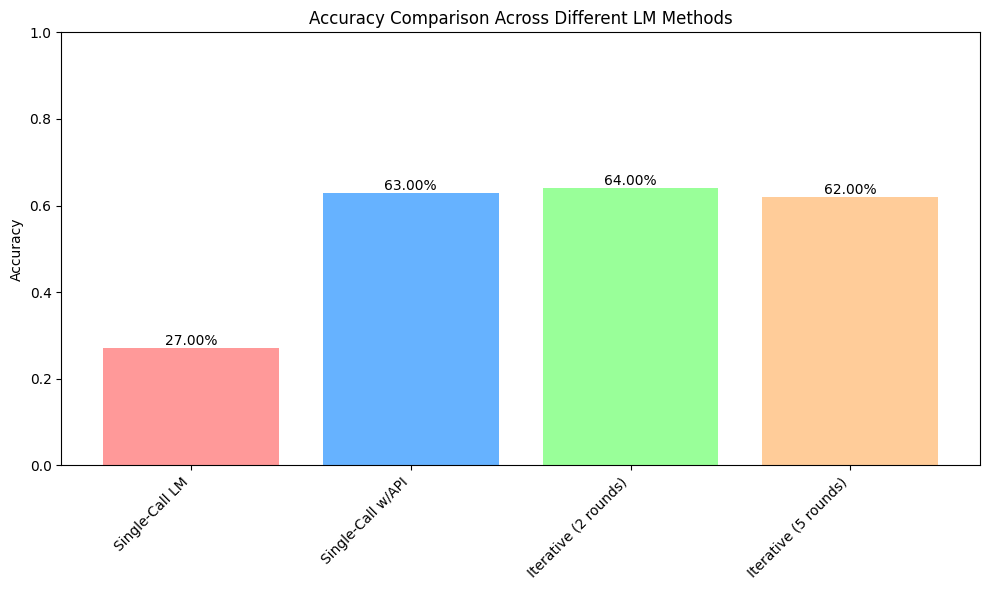

In [16]:
from matplotlib import pyplot as plt

# Create data for the bar graph
methods = ['Single-Call LM', 'Single-Call w/API', 'Iterative (2 rounds)', 'Iterative (5 rounds)']

# Must be in this order and in floating point format from 0.0 to 1.0
accuracies = [
    accuracy_singleLM / 100,
    accuracy_querydecomposition / 100, 
    accuracy_iterative_refinement / 100,
    accuracy_multi_round_iterative_refinement / 100
]

# Define colors for each bar
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracies, color=colors)

# Customize the plot
plt.title('Accuracy Comparison Across Different LM Methods')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)  # Set y-axis from 0 to 1 since these are accuracy values

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}',
             ha='center', va='bottom')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

## Part 3 - Building an LLM Agentic Workflow [20 points]

Using the components we've built (or new ones you've implemented), build an LLM agent that can answer the following questions about the world. These questions will be a mix of the types of questions we've built components for and will require using the APIs in creative ways.

Some questions will require just a single API call, while others will require multiple API calls and multiple rounds of iterative refinement. Create a pipeline that can dynamically adjust to the complexity of the question. Feel free to implement new components or use the ones we've already built!

If you get above 70% accuracy on the test set, you will get full points. For scores below 70%, you will get partial credit based on the percentage of accuracy. With each of the components currently implemented, the agent should be capable of getting above 70% accuracy on the test set.

**Important**: Make sure to evaluate over the entire dataset when you are confident with your implementation! This will help you preserve inference compute credits and speed up the development process. Also, please use `gpt-4o`, `claude-3-5-sonnet-20241022`, and `meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo` for the decomposition, iterative refinement, and fusion models.

Deliverable: In the `cs329_hw2/multi_lm_agent.py` file, implement the `run_pipeline` method in the MultiLMAgent class. It should take a query and return a response. Furthermore, it should be able to handle all the queries outlined below before the responses are evaluated.

**Note**: How does the performance on the dataset compare between single-call LMs vs. the complete pipeline with the multi-LM agent? How does it improve accuracy by improving access to tool APIs and allowing for more complex reasoning?

Let's first evaluate over the entire dataset with just a single model
- **IMPORTANT**: Make sure to evaluate over the entire dataset when you are confident with your implementation! 
- This will help you preserve inference compute credits and speed up the development process.

In [17]:
# Let's first evaluate over the entire dataset with just a single model
# IMPORTANT: Make sure to evaluate over the entire dataset when you are confident with your implementation! 
# This will help you preserve inference compute credits and speed up the development process.

from cs329_hw2.evaluation import evaluate_qa

debug_mode = False # Loads the entire test dataset for evaluation.
dataset = prepare_dataset(debug_mode=debug_mode)

test_queries = dataset['train']['query']
answers = dataset['train']['answer']

single_model_responses = []
from tqdm import tqdm

for query, answer in tqdm(zip(test_queries, answers), total=len(test_queries)):
    response = multi_lm_agent.generate(query, model="gpt-4o")
    single_model_responses.append(response)

print("Evaluating single-model performance...")
complete_set_single_model_accuracy, complete_set_single_model_results = evaluate_qa(test_queries, single_model_responses, answers)
print(complete_set_single_model_accuracy)

100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


Evaluating single-model performance...


100%|██████████| 100/100 [02:41<00:00,  1.62s/it]

23.0


Now let's evaluate over the entire dataset with our multi-LM agentic pipeline
- **IMPORTANT**: Make sure to evaluate over the entire dataset when you are confident with your implementation! 
- This will help you preserve inference compute credits and speed up the development process.

In [ ]:
from cs329_hw2.evaluation import evaluate_qa

debug_mode = False # Loads the entire test dataset for evaluation.
dataset = prepare_dataset(debug_mode=debug_mode)

test_queries = dataset['train']['query']
answers = dataset['train']['answer']

# multi_lm_agent = MultiLMAgent(api_manager,
#                               decomposition_model="meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo",
#                               iterative_refinement_model="claude-3-5-sonnet-20241022",
#                               fusion_model="gpt-4o")

multi_lm_agent = MultiLMAgent(api_manager)

multi_lm_responses = []
print("\nGenerating responses with Multi-LM Agent...")

from tqdm import tqdm

for query, answer in tqdm(zip(queries, answers), total=len(queries)):
    response = multi_lm_agent.run_pipeline(query, 5)
    multi_lm_responses.append(response)

print("Evaluating multi-LM agent performance...")
complete_set_agentic_accuracy, complete_set_agentic_results = evaluate_qa(test_queries, multi_lm_responses, answers)
print(complete_set_agentic_accuracy)


Generating responses with Multi-LM Agent...


 92%|█████████▏| 92/100 [4:56:48<21:23, 160.40s/it]   

Create a bar graph plotting the accuracies of single-call and multi-call with 5 maximum rounds of iterative refinement on the entire test set

In [ ]:
from matplotlib import pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 6))

# Data for plotting
models = ['Single-Model', 'Multi-LM Agent']
accuracies = [complete_set_single_model_accuracy / 100, complete_set_agentic_accuracy / 100]

# Create bars
bars = plt.bar(models, accuracies)

# Customize the plot
plt.title('Comparison of Single-Model vs Multi-LM Agent Performance', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.0)  # Set y-axis from 0 to 1

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}',
             ha='center', va='bottom')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

## Part 4 - Deep Research Agent [20 bonus points]

Agentic LM systems are used everywhere today! From chatbots to coding agents to task automation, they are becoming more and more prevalent in our daily lives. Recently, OpenAI released "Deep Research", an reasoning LM agent capable of synthesizing large amounts of online information and completing multi-step research tasks: [Introducing Deep Research](https://openai.com/index/introducing-deep-research/). Google also released a similar product [Deep Research](https://blog.google/products/gemini/google-gemini-deep-research/) in December.

Using the components we've built and extending them if needed, implement your own deep research agent that can generate comprehensive analyses from online sources. The agent should be able to handle complex queries requiring multi-step research, synthesizing information from multiple sources, and generating a comprehensive final report.

**Key requirements for implementation:**
- Generate a four-five paragraph report
- Proper, easy-to-read structuring of the report
- Usage of multiple sources of information with appropriate link citations
- Track temporal information and maintain chronological accuracy

Deliverable: In the `cs329_hw2/deep_research_agent.py` file, implement the `research` method in the `DeepResearchAgent` class.

The method should:
- Take a complex query (e.g., "What was the UK's macroeconomic performance in 2024?")
- Break it down into sub-questions
- Research each sub-question using the search engine API
- Synthesize and summarize findings with appropriate formatting as a report
- Return a report and list of sources 
- **IMPORTANT**: Make sure to use cheaper models during the development process to help you preserve inference compute credits and speed up the process!

In [ ]:
from cs329_hw2.DeepResearchAgent import DeepResearchAgent
import os
from dotenv import load_dotenv
from cs329_hw2.api_manager import APIManager

# Load environment variables from .env file
load_dotenv()

# Get API keys
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
GOOGLE_CX_ID = os.getenv('GOOGLE_CX_ID')
ALPHA_VANTAGE_KEY = os.getenv('ALPHA_VANTAGE_KEY')


if not GOOGLE_API_KEY or not ALPHA_VANTAGE_KEY:
    raise ValueError("Missing required API keys in environment variables")

# Initialize API manager with keys
api_manager = APIManager(
    google_api_key=GOOGLE_API_KEY,
    google_cx_id=GOOGLE_CX_ID,
    alpha_vantage_key=ALPHA_VANTAGE_KEY
)

test_queries = [
    "What are the key developments and challenges in solid-state battery technology for electric vehicles in 2024, including major company announcements and technical breakthroughs?",
    "How has the implementation of the UK's post-Brexit immigration policy affected its labor market and key industries between 2021-2024? Include specific policy changes and their measured impacts.",
    "What progress has been made in nuclear fusion energy in 2024, focusing on major research milestones, private sector investments, and timeline predictions for commercial viability?"
]

custom_agent = DeepResearchAgent(api_manager)

for query in test_queries:
    print(f"\nQuery: {query}")
    single_LM_response = multi_lm_agent.generate(query, model="gpt-4o")
    report = custom_agent.research(query)
    print(f"Single-LM Response: {single_LM_response}")
    print("\n" * 3)
    print(f"Report: {report['report']}")
    # print(f"Sources: {report['sources']}") # Skipping sources as there is an increidbyl high amount of sources used in the answer.
    print("-" * 50)
    print("-" * 50)